In [158]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [159]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from rag.pdf import PDFRetrievalChain
from langchain_teddynote.tools.tavily import TavilySearch

from typing import List, Literal
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_core.documents import Document

In [160]:
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        documents: 도큐먼트 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

### PDF 기반 문서 검색기 (Retrieval chain) 생성

In [161]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

### PDF 기반 문서 검색기 (Retrieval chain) : 사용자 질문에 대한 PDF 문서를 검색

In [162]:
# 문서 검색 노드
def retrieve(state: GraphState):
    # print('\n==========================================================================================')
    # print(f"🔄 [Node] 문서 검색 노드 🔄")
    
    # 사용자 질문
    question = state['question']        

    # 문서 검색 (pdf_retriever 에 사용자 입력을 인자로 넣어서 문서를 검색)
    documents = pdf_retriever.invoke(question)
    
    # print(f'문서 검색 결과: ')
    # print('-------------------')
    # print(documents)
    # print('-------------------')
    # print('==========================================================================================\n')
    
    return {'documents': documents}

### 답변 생성을 위한 RAG 체인

In [163]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain import hub

# prompt = hub.pull("teddynote/rag-prompt")

template = """You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If you can't find the source of the answer, you should answer that you don't know.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

# Your final ANSWER to the user's QUESTION:"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

output_parser = StrOutputParser()

# RAG 체인 생성 (pdf_retriever 문서 검색기를 사용해서 얻은 문서와 사용자 질문을 넣어서 결과)
rag_chain = prompt | llm | output_parser

### 답변 생성을 위한 RAG 체인을 실행하여 사용자 질문에 대한 답변을 생성하는 노드

In [164]:
# 답변 생성 노드
def generate(state: GraphState):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 답변 생성 노드 🔄')

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # RAG 실행 결과
    generation = rag_chain.invoke({'context': documents , 'question': 'question'})

    # print('-------------------')
    # print(f'(1) 사용자 질문: {question}')
    # print(f'(2) 문서 검색 결과:')
    # print(documents)
    # print()
    # print(f'(3) rag 실행 결과:')
    # print(generation)
    # print('-------------------')

    # print()
    # print('==========================================================================================\n')    

    return {'generation': generation}

### 문서 검색 평가기 (Retrieval Grader)

In [165]:
class GradeDocuments(BaseModel):        # 문서 평가를 위한 데이터 모델
    """Binary score for relevance check on retrieved documents."""

    # 사용자 질문에 대한 pdf 문서 검색 결과를 평가하는 문서 검색 평가기(retrieval_grader)를 사용해서 
    # 사용자 질문과 검색 결과문서가 관련성이 있는지 본다

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 메시지
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 프롬프트 템플릿
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 문서 검색결과 평가기
retrieval_grader = grade_prompt | structured_llm_grader

### 사용자 질문에 대한 pdf 문서 검색 결과의 관련성을 평가하는 문서 검색 평가기(retrieval_grader) 노드

In [166]:
# 문서 검색 결과와 질문 관련성 평가 노드
def grade_documents(state: GraphState):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 문서 검색 결과와 질문 관련성 평가 노드 🔄')

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # 문서 검색 평가기를 통과한 문서들만 필터링
    filtered_docs = []

    for doc in documents:
        score = retrieval_grader.invoke({'question': question, 'document': doc.page_content})

        grade = score.binary_score

        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")     
            filtered_docs.append(doc)                   
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---") 
            continue     

    # print('==========================================================================================\n')
    return {'documents': filtered_docs}

### 쿼리 재작성 (Query Rewriter)

In [167]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# Query Rewriter 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_writer_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', 'Here is the initial question: \n\n {question} \n Formulate an improved question')
    ]
)

# Query Rewriter 생성
question_rewriter = re_writer_prompt | llm | StrOutputParser()

### Query Rewrite 노드

In [168]:
# Query Rewrite 노드
def transform_query(state: GraphState):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 쿼리 재작성 노드 🔄')

    # 사용자 질문
    question = state['question']

    # 문서 검색 결과
    documents = state['documents']

    
    # 쿼리 재작성
    better_question = question_rewriter.invoke({'question': question})
    
    # print('-------------------')
    # print(f"better_question: {better_question}")
    # print('-------------------')
    
    # print('==========================================================================================\n')

    return {'question': better_question}

### 웹 검색 도구

In [169]:
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색 도구 생성
web_search_tool = TavilySearch(max_results=3)

### 웹 검색 노드

In [170]:
# 웹 검색 노드
def web_search(state):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 웹 검색 노드 🔄')

    # 사용자 질문
    question = state['question']
    
    # print('-------------------')
    # print(f"question: ")
    # print(question)
    # print('-------------------')
    # print()

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})

    # print('-------------------')
    # print('web_results: ')
    # print(web_results)
    # print('-------------------')
    # print()

    web_results_docs = []
    
    for result in web_results:
        doc = Document(
            page_content=result["content"],
            metadata={"source": result["url"]}
        )
        web_results_docs.append(doc)

    # print('-------------------')
    # print(web_results_docs)
    # print('-------------------')
    # print()
    # print('==========================================================================================\n')

    return {"documents": web_results_docs}

### 질문 라우팅 노드

In [171]:
class RouteQuery(BaseModel):    
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# 구조화된 출력을 결과로 가젼온다 (vectorstore, web_search)
structured_llm_router = llm.with_structured_output(RouteQuery)

# 시스템 메시지
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to DEC 2023 AI Brief Report(SPRI) with Samsung Gause, Anthropic, etc.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# 프롬프트
route_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', '{question}')
    ]
)

question_router = route_prompt | structured_llm_router

In [172]:
# 질문 라우팅 노드
def route_question(state: GraphState):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 질문 라우팅 노드 🔄')

    # 사용자 질문
    question = state['question']

    # 질문 라우팅
    source = question_router.invoke({'question': question})

    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        # print('==========================================================================================\n')
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        # print('==========================================================================================\n')
        return "vectorstore"

### 문서 관련성 평가 노드

In [173]:
# 문서 관련성 평가 노드
def decide_to_generate(state: GraphState):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 문서 관련성 평가 노드 🔄')

    # 문서 검색 결과 가져오기
    filtered_documents = state['documents']

    if not filtered_documents:                              # 문서가 없는 경우 (모든 문서가 관련성 없는 문서)
        print(f'===== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] =====')
        # print('==========================================================================================\n')
        return "transform_query"        
    else:                                                   # 관련성 있는 문서가 있는 경우
        print(f"===== [DECISION: GENERATE] =====")
        # print('==========================================================================================\n')
        return "generate"

# 답변에 대한 Hallucination checker 추가

In [174]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_hallucination_grader = llm.with_structured_output(GradeHallucinations)

# system
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 프롬프트
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
) 

# hallucination 평가기 생성
hallucination_grader = hallucination_prompt | structured_hallucination_grader

In [175]:
class GradeAnswer(BaseModel):
    """Binary scoring to evaluate the appropriateness of answers to questions"""

    binary_score: str = Field(
        description="Indicate 'yes' or 'no' whether the answer solves the question"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# system
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 템플릿
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader

In [176]:
# Hallucination 평가 노드
def hallucination_check(state: GraphState):
    # print('\n==========================================================================================')
    # print('🔄 [Node] hallucination 평가 노드 🔄')

    # 사용자 질문
    qestion = state['question']

    # 문서 검색 결과
    documents = state['documents']

    # 생성된 답변
    generation = state['generation']

    # 평가
    score = hallucination_grader.invoke({'documents': documents, 'generation': generation})
    grade = score.binary_score

    # print(f"===== [평가 결과] =====")
    # print(grade)

    if grade == 'yes':     # hallucination 없음
        print("===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====")
        print("no hallucination")
        print()

        # 답변에 대한 관련성 평가
        print("===== [GRADE GENERATED ANSWER vs QUESTION] =====")

        score = answer_grader.invoke({'question': state['question'], 'generation': generation})
        grade = score.binary_score

        if grade == 'yes':          # 관련성 있는 답변
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            print("relevant")
            # print('==========================================================================================\n')
            return "relevant"
        else:                       # 관련성 없는 답변
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            print("not relevant")
            print()
            # print('==========================================================================================\n')
            return "not relevant"

    else:                   # hallucination 있음
        print("===== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] =====")
        print("hallucination")
        print()
        # print('==========================================================================================\n')
        return "hallucination"

In [177]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

In [178]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [179]:
######### 2. 노드 정의  #########

workflow.add_node('web_search', web_search)                 # 웹 검색  
workflow.add_node('retrieve', retrieve)                     # 문서 검색 노드
workflow.add_node('grade_documents', grade_documents)       # 문서 검색으로 가져온 결과와 사용자 질문의 관련성을 평가하는 노드
workflow.add_node('generate', generate)                     # 사용자 질문과 문서 검색결과를 가지고 답변 생성하는 노드
workflow.add_node('transform_query', transform_query)       # 사용자 질문(쿼리)를 재작성하는 노드

In [180]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_conditional_edges(
    START, 
    route_question,                     # 질문 라우팅 노드  
    {
        'web_search': 'web_search',     # 웹 검색으로 라우팅
        'vectorstore': 'retrieve'       # retrieve (PDF 문서 검색)로 라우팅
    }
)

In [181]:
workflow.add_edge('web_search', 'generate')         # 웹 검색하고 답변 생성
workflow.add_edge('retrieve', 'grade_documents')    # retrieve 노드에서 PDF 문서 검색실행 하고 결과를 문서 검색 평가기로 가서 평가

In [182]:
workflow.add_conditional_edges(
    'grade_documents',                              # 문서 검색으로 가져온 결과와 사용자 질문의 관련성을 평가하는 노드
    decide_to_generate,                             # 문서 관련성 평가
    {
        'transform_query': 'transform_query',       # 사용자 입력 다시 작성 필요
        'generate': 'generate'                      # 답변 생성
    }
)

In [183]:
workflow.add_edge('transform_query', 'retrieve')    # 쿼리 다시 작성한 뒤 문서 검색

In [184]:
workflow.add_conditional_edges(
    'generate',
    hallucination_check,
    {
        'hallucination': 'generate',                # Hallucination 발생 시 재생성
        'relevant': END,                            # 답변 관련성 통과     
        'not relevant': 'transform_query'           # 딥변 관련성 통과 못하는 경우. 쿼리 다시 작성
    }
)

In [185]:
######### 4. 체크 포인터 설정  #########

memory = MemorySaver()

In [186]:
######### 5. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

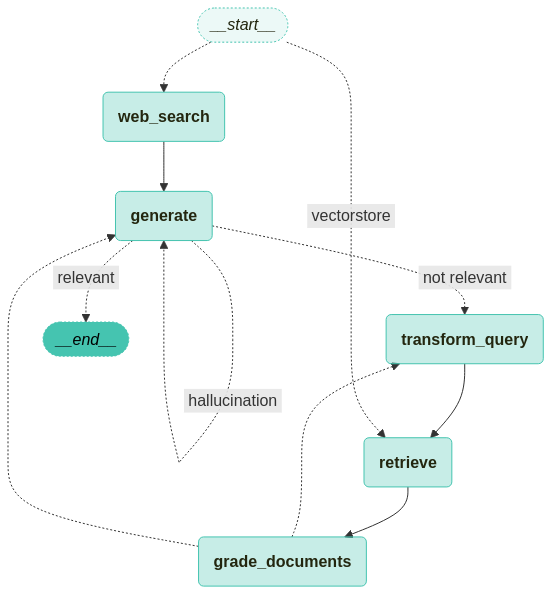

In [187]:
visualize_graph(app)

In [188]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

In [189]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 교보문고')


i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1

    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        print(f"state_value: \n {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

==== [ROUTE QUESTION TO WEB SEARCH] ====
===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : web_search
state_value: 
 {'documents': [Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://store.kyobobook.co.kr/store-info/004'}, page_content="대구점 매장안내 - 교보문고 브랜드 더보기 회원가입 로그인 회원혜택 주문배송 매장안내 고객센터 통합검색 search button 전체메뉴 책!책!책! 신학기혜택 베스트 신상품 이벤트 바로펀딩 PICKS CASTing 컬처라운지 오늘의 미션 할인혜택 드디어 책책책 공개! 대구점 MY매장 서울 경기/인천 수도권 외 로그인 후 MY매장을 설정해 보세요. 설정하기 대구점 마이매장 설정 매장주소 

In [190]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 생성한 AI')


i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1

    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key}")
        print(f"state_value : {state_value}")

        if state_key == 'web_search':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            print()
        elif state_key == 'transform_query':
            print('------------------------------')
            print(f"🔄 [Node] 쿼리 재작성 노드 🔄")
            print(f"{state_value['question']}")
            print('------------------------------')
            print()
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 결과와 질문 관련성 평가 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()

        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

==== [ROUTE QUESTION TO VECTORSTORE] ====
===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : retrieve
state_value : {'documents': [Document(id='6398510f-79f4-4b4f-b109-b0f475eeb2cb', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='9b3c96ce-f825-49d8-8f4e-acf9baaecda8', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author':

In [191]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 교보문고')


i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1

    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key}")
        print(f"state_value : {state_value}")

        if state_key == 'web_search':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            print()
        elif state_key == 'transform_query':
            print('------------------------------')
            print(f"🔄 [Node] 쿼리 재작성 노드 🔄")
            print(f"{state_value['question']}")
            print('------------------------------')
            print()
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 결과와 질문 관련성 평가 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()

        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

==== [ROUTE QUESTION TO WEB SEARCH] ====
===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : web_search
state_value : {'documents': [Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}, page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는'), Document(metadata={'source': 'https://store.kyobobook.co.kr/store-info/004'}, page_content="대구점 매장안내 - 교보문고 브랜드 더보기 회원가입 로그인 회원혜택 주문배송 매장안내 고객센터 통합검색 search button 전체메뉴 책!책!책! 신학기혜택 베스트 신상품 이벤트 바로펀딩 PICKS CASTing 컬처라운지 오늘의 미션 할인혜택 드디어 책책책 공개! 대구점 MY매장 서울 경기/인천 수도권 외 로그인 후 MY매장을 설정해 보세요. 설정하기 대구점 마이매장 설정 매장주소 대

In [197]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 교보문고')


for chunk in app.stream(inputs, config=config, stream_mode="updates"):

    for state_key, state_value in chunk.items():

        print('\n==================================================')

        if state_key == 'web_search':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            # print(f"{state_value['documents']}")

            for doc in state_value['documents']:
                print(doc)

            print('------------------------------')

        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
        elif state_key == 'transform_query':
            print('------------------------------')
            print(f"🔄 [Node] 쿼리 재작성 노드 🔄")
            print(f"{state_value['question']}")
            print('------------------------------')
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 결과와 질문 관련성 평가 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')

        print('==================================================\n')

==== [ROUTE QUESTION TO WEB SEARCH] ====

------------------------------
🔄 [Node] 웹 검색 노드 🔄
page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는' metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}
page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는' metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}
page_content='대구점 매장안내 - 교보문고 브랜드 더보기 회원가입 로그인 회원혜택 주문배송 매장안내 고객센터 통합검색 search button 전체메뉴 책!책!책! 신학기혜택 베스트 신상품 이벤트 바로펀딩 PICKS CASTing 컬처라운지 오늘의 미션 할인혜택 드디어 책책책 공개! 대구점 MY매장 서울 경기/인천 수도권 외 로그인 후 MY매장을 설정해 보세요. 설정하기 대구점 마이매장 설정 매장주소 대구광역시 중구 국채보상로 586, 교보생명빌딩 1~3층 *   영업시간 *   휴점 설(당일), 추석(당일) 지도 보기매장 문의 053-425-3501 Notice 김재원 아나운서의 힐링 에세이 '엄마의 얼굴' 사인회 코미디언 이경규의 첫 에세이 '삶이라는

In [204]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 만든 생성형 AI')


for chunk in app.stream(inputs, config=config, stream_mode="updates"):

    for state_key, state_value in chunk.items():

        print('\n==================================================')

        if state_key == 'web_search':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            # print(f"{state_value['documents']}")

            for doc in state_value['documents']:
                print(doc)

            print('------------------------------')

        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            # print(f"{state_value['documents']}")
            
            for doc in state_value['documents']:
                print(doc)

            print('------------------------------')
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
        elif state_key == 'transform_query':
            print('------------------------------')
            print(f"🔄 [Node] 쿼리 재작성 노드 🔄")
            print(f"{state_value['question']}")
            print('------------------------------')
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 결과와 질문 관련성 평가 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')

        print('==================================================\n')

==== [ROUTE QUESTION TO VECTORSTORE] ====

------------------------------
🔄 [Node] 문서 검색 노드 🔄
page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12' metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}
page_content='SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원

In [205]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 만든 생성형 AI')

invoke_graph(app, inputs, config)

==== [ROUTE QUESTION TO VECTORSTORE] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12' metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}
page_content='SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 

In [206]:
def invoke_graph_(graph=app, inputs=inputs, config=config):
    for chunk in app.stream(inputs, config=config, stream_mode="updates"):

        for state_key, state_value in chunk.items():

            print('\n==================================================')

            if state_key == 'web_search':
                print('------------------------------')
                print(f"🔄 [Node] 웹 검색 노드 🔄")
                # print(f"{state_value['documents']}")

                for doc in state_value['documents']:
                    print(doc)

                print('------------------------------')

            elif state_key == 'retrieve':
                print('------------------------------')
                print(f"🔄 [Node] 문서 검색 노드 🔄")
                # print(f"{state_value['documents']}")
                
                for doc in state_value['documents']:
                    print(doc)

                print('------------------------------')
            elif state_key == 'generate':
                print('------------------------------')
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                print(f"{state_value['generation']}")
                print('------------------------------')
            elif state_key == 'transform_query':
                print('------------------------------')
                print(f"🔄 [Node] 쿼리 재작성 노드 🔄")
                print(f"{state_value['question']}")
                print('------------------------------')
            elif state_key == 'grade_documents':
                print('------------------------------')
                print(f"🔄 [Node] 문서 검색 결과와 질문 관련성 평가 노드 🔄")
                print(f"{state_value['documents']}")
                print('------------------------------')

            print('==================================================\n')

In [207]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 교보문고')

invoke_graph_(app, inputs, config)

==== [ROUTE QUESTION TO WEB SEARCH] ====

------------------------------
🔄 [Node] 웹 검색 노드 🔄
page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는' metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}
page_content='국민정신문화 향상, 사회교육적 기능을 살린 문화공간을 창출하는 문고 대구광역시 중구 동성로2가 위치, 영업점, 이벤트, 행사 등 안내, 보유도서 검색 제공. 대구의 중심가 동성로에 있는 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 바탕으로 대구를 대표하는' metadata={'source': 'https://www.localview.co.kr/store/detail.asp?seq=600977851'}
page_content='대구점 매장안내 - 교보문고 브랜드 더보기 회원가입 로그인 회원혜택 주문배송 매장안내 고객센터 통합검색 search button 전체메뉴 책!책!책! 신학기혜택 베스트 신상품 이벤트 바로펀딩 PICKS CASTing 컬처라운지 오늘의 미션 할인혜택 드디어 책책책 공개! 대구점 MY매장 서울 경기/인천 수도권 외 로그인 후 MY매장을 설정해 보세요. 설정하기 대구점 마이매장 설정 매장주소 대구광역시 중구 국채보상로 586, 교보생명빌딩 1~3층 *   영업시간 *   휴점 설(당일), 추석(당일) 지도 보기매장 문의 053-425-3501 Notice 김재원 아나운서의 힐링 에세이 '엄마의 얼굴' 사인회 코미디언 이경규의 첫 에세이 '삶이라는

In [208]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 만든 생성형 AI 이름')

invoke_graph_(app, inputs, config)

==== [ROUTE QUESTION TO VECTORSTORE] ====

------------------------------
🔄 [Node] 문서 검색 노드 🔄
page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12' metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}
page_content='SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원